In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams.update({'font.size': 22})

In [2]:
df= pd.read_csv("data/clean_train.csv")

In [3]:
df.head()

,id,url,title,target,title_tokens,in_black_list,bad_title
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False,"['экс', 'министр', 'экономик', 'молдов', 'глав...",0,0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False,"['песн', 'стал', 'известн', 'мног', 'телезрите...",0,0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False,"['банш', 'сезон', 'сер', 'брем', 'красот', 'см...",0,0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False,"['бес', 'картинк']",0,0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False,"['новомосковск', 'сыгра', 'следж', 'хоккеист',...",0,0


In [4]:
print('shape:', df.shape, '\n')
df.info();

shape: (135309, 7) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135309 entries, 0 to 135308
Data columns (total 7 columns):
id               135309 non-null int64
url              135309 non-null object
title            135309 non-null object
target           135309 non-null bool
title_tokens     135309 non-null object
in_black_list    135309 non-null int64
bad_title        135309 non-null int64
dtypes: bool(1), int64(3), object(3)
memory usage: 6.3+ MB


False    118594
True      16715
Name: target, dtype: int64


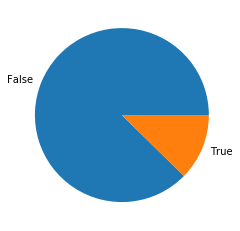

In [5]:
print(df.target.value_counts())
plt.pie(df.target.value_counts(),labels=[False,True]);

# Сплитим 80/20

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
df_train, df_test, y_train, y_test = train_test_split(df.drop('target', axis = 1), df.target, random_state=7)

In [40]:
#df_train, y_train = df.drop('target', axis = 1), df.target.values
#для обучения на полном тренеровочном датафрейме

# Title+url (TF-IDF)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

In [10]:
X_train = df_train['url'].values + ' ' + df_train['title_tokens'].values
X_test = df_test['url'].values + ' ' + df_test['title_tokens'].values

In [11]:
tfidf_vectorizer.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [12]:
len(tfidf_vectorizer.get_feature_names())

604943

In [13]:
vect_train = tfidf_vectorizer.transform(X_train)

# Title+url (LogReg)

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
LogReg_model = LogisticRegression( C=1000, n_jobs= 4)

In [16]:
LogReg_model.fit(vect_train, y_train)

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=4,
          penalty='l2', random_state=None, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)

In [17]:
from sklearn.metrics import f1_score

In [18]:
f1_score(y_train, 
        LogReg_model.predict(vect_train))

0.999640933572711

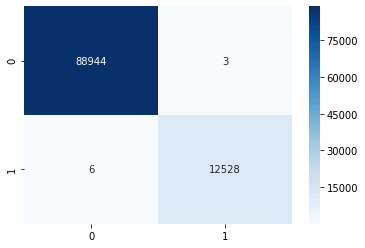

In [19]:
from sklearn.metrics import confusion_matrix
sns.heatmap( 
    confusion_matrix(y_train, LogReg_model.predict(vect_train)),
    annot= True,
    fmt='d',
    cmap='Blues'
)

# Для оставшегося кусочка 20%

In [20]:
vect_test = tfidf_vectorizer.transform(X_test)

In [21]:
f1_score(
    LogReg_model.predict(vect_test),
    y_test
    )

0.975779376498801

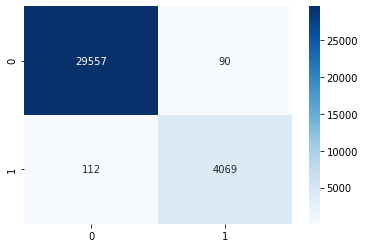

In [22]:
sns.heatmap( 
    confusion_matrix(y_test, LogReg_model.predict(vect_test)),
    annot= True,
    fmt='d',
    cmap='Blues'
)

In [23]:
df_test['LogReg'] = LogReg_model.predict(vect_test).astype(int)

## Добавим результаты из "черного списка"

In [24]:
df_test['predict'] = df_test.apply(lambda x: bool(x['in_black_list'] or x['bad_title'] or x['LogReg']), axis=1)

In [25]:
f1_score(
    df_test['predict'],
    y_test
    )

0.9765156961418644

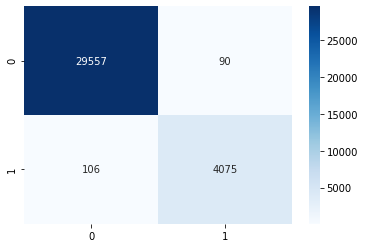

In [26]:
sns.heatmap( 
    confusion_matrix(y_test, df_test['predict']),
    annot= True,
    fmt='d',
    cmap='Blues'
)

# нужно понизить кол-во ложно отрицательных результатов

In [27]:
mask = df_test[~df_test.predict]['url'].map(lambda x: ('porno' in x) or ('xxx' in x) or ('xvideo' in x))

In [28]:
df_test[~df_test.predict][mask]

,id,url,title,title_tokens,in_black_list,bad_title,LogReg,predict
101820,101820,pornorus.org,Результаты поиска по Пикап,"['результат', 'поиск', 'пикап']",0,0,0,False
90817,90817,iiporno-online.ru,Катя отдалась старику,"['кат', 'отда', 'старик']",0,0,0,False
11796,11796,pornoeva.ru,Блондиночка лежит на бильярдном столе и приним...,"['блондиночк', 'леж', 'бильярдн', 'стол', 'при...",0,0,0,False
75212,75212,pornopati.net,Главное чтоб жопа дышала,"['главн', 'жоп', 'дыша']",0,0,0,False
118858,118858,pornodom.xyz,Вы искали студентку - PornoDom.xyz,"['иска', 'студентк', 'pornod', 'xyz']",0,0,0,False
129889,129889,tytporno.online,Онаниста запалили за рукоблудием и помогли кон...,"['онанист', 'запал', 'рукоблуд', 'помогл', 'ко...",0,0,0,False
43028,43028,www.pornotales.net,Шантажист (ка),"['шантажист', 'ка']",0,0,0,False
19431,19431,xxxsexporno.org,Поиск видео по: Узбечка,"['поиск', 'виде', 'узбечк']",0,0,0,False
49940,49940,www.maloporno.com,Поиск видео: Воровка,"['поиск', 'виде', 'воровк']",0,0,0,False
112588,112588,pornoanal.tv,Все популярные видео с аналом смотреть онлайн ...,"['популярн', 'виде', 'анал', 'смотрет', 'онлай...",0,0,0,False


In [29]:
df_test['predict'] = df_test.apply(lambda x:  x['predict'] or 
                                               ('porn' in x['url']) or
                                                   ('xxx' in x['url']) or
                                                       ('xvideo' in x['url']) , axis = 1)

In [30]:
f1_score(
    df_test['predict'],
    y_test
    )

0.9783518717856716

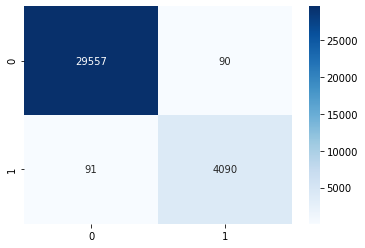

In [31]:
sns.heatmap( 
    confusion_matrix(y_test, df_test['predict']),
    annot= True,
    fmt='d',
    cmap='Blues'
)

# Предсказание

In [32]:
df_pred = pd.read_csv("data/clean_test.csv")
df_pred.head(5)

,id,url,title,target,title_tokens,in_black_list,bad_title
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False,"['экс', 'министр', 'экономик', 'молдов', 'глав...",0,0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False,"['песн', 'стал', 'известн', 'мног', 'телезрите...",0,0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False,"['банш', 'сезон', 'сер', 'брем', 'красот', 'см...",0,0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False,"['бес', 'картинк']",0,0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False,"['новомосковск', 'сыгра', 'следж', 'хоккеист',...",0,0


In [33]:
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135309 entries, 0 to 135308
Data columns (total 7 columns):
id               135309 non-null int64
url              135309 non-null object
title            135309 non-null object
target           135309 non-null bool
title_tokens     135309 non-null object
in_black_list    135309 non-null int64
bad_title        135309 non-null int64
dtypes: bool(1), int64(3), object(3)
memory usage: 6.3+ MB


In [34]:
vect_pred = tfidf_vectorizer.transform(
                            df_pred['url'].values + ' ' + df_pred['title_tokens'].values
                            )

In [35]:
df_pred['LogReg'] = LogReg_model.predict(vect_pred)

In [36]:
df_pred['target'] = df_pred.apply(lambda x: bool(x['in_black_list'] or x['bad_title'] or x['LogReg']), axis=1)

In [37]:
df_pred['target'] = df_pred.apply(lambda x:  x['target'] or 
                                               ('porn' in x['url']) or
                                                   ('xxx' in x['url']) or
                                                       ('xvideo' in x['url']) , axis = 1)

In [38]:
df_pred[df_pred.target]

,id,url,title,target,title_tokens,in_black_list,bad_title,LogReg
8,8,xlecx.com,league of legends » Page 5 » Porn comics free ...,True,"['leag', 'legend', 'pag', 'porn', 'comic', 'fr...",0,1,True
12,12,pornmult.info,"кримпай,мать и сын » Страница 5 » смотреть пор...",True,"['кримпа', 'мат', 'сын', 'страниц', 'смотрет',...",1,1,True
19,19,24eropixel.net,Мужик поставил блондинку раком и отодрал ее ту...,True,"['мужик', 'постав', 'блондинк', 'рак', 'отодра...",1,1,True
21,21,gdespaces.com,Порно которое ты искал / Видео - Spaces.ru / S...,True,"['порн', 'котор', 'иска', 'виде', 'spac', 'ru'...",0,0,True
41,41,hdxclub.com,Лесбийский секс с кунилингусом двух стройных с...,True,"['лесбийск', 'секс', 'кунилингус', 'стройн', '...",1,1,True
47,47,jrfzdohkntmopulam5635ayigseqr47ghplfa5l67uo72g...,Lesbians Monique Alexander and Violet Starr fu...,True,"['lesbia', 'moniq', 'alexand', 'violet', 'star...",1,1,True
52,52,desixxxtube.pro,Indian aunty bjowjob and fucking with her part...,True,"['india', 'aunt', 'bjowjob', 'fuck', 'partner'...",0,0,True
53,53,ipad.perfektdamen.co,"Sweet, Russian honey, Angelika got down and di...",True,"['sweet', 'russia', 'hone', 'angelik', 'got', ...",0,1,True
55,55,daftsex.com,Playlist Lesbian — DaftSex,True,"['playlist', 'lesbia', 'daftsex']",1,0,True
56,56,topdevka.com,Фото голых девочек и бесплатная эротика на Top...,True,"['фот', 'гол', 'девочек', 'бесплатн', 'эротик'...",0,0,True


In [39]:
 df_pred[["id", "target"]].to_csv("y_pred.csv", index=False)

!cat y_pred.csv | head

id,target
0,False
1,False
2,False
3,False
4,False
5,False
6,False
7,False
8,True
cat: ошибка записи: Обрыв канала
